# INTRODUCTION TO THE PROBLEM AND DATASET

## PROBLEM STATEMENT

> Social media platforms generate massive amounts of textual data daily, with users sharing thoughts, opinions, and news in real time. However, extracting meaningful insights from this unstructured data is challenging, especially when users do not follow a standardized format. Many users **avoid using hashtags**, use **misspelled or incorrect tags**, or post without explicit context, making it difficult to track trends, identify topics, or categorize content accurately.  

> To address this challenge, **Named Entity Recognition (NER)** is used to automatically extract key entities such as **persons, locations, organizations, products, and more** from social media text. Traditional NER models often struggle with informal language, abbreviations, and limited context in short-form text. Hence, a robust deep learning-based NER system is required to effectively identify and classify entities without relying on hashtags or predefined tags.

## OBJECTIVE OF THE PROJECT

> The objective of this project is to **develop a fine-grained Named Entity Recognition (NER) system** for short-text data using **deep learning models** like **LSTM-CRF and Transformer-based architectures (e.g., BERT)**. The system will automatically identify and classify entities such as **persons, locations, organizations, products, and more**, without relying on hashtags or predefined tags.  

> This project involves **preprocessing text in CoNLL format, tokenization, training multiple models, optimizing hyperparameters, and evaluating performance**. By comparing traditional and transformer-based approaches, the goal is to build a robust NER system capable of accurately extracting named entities from informal and unstructured social media text.

## IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## IMPORT DATASET

### **What is CoNLL?**  

**CoNLL (Conference on Computational Natural Language Learning)** is an annual conference focused on Natural Language Processing (NLP) and Machine Learning (ML). It has hosted several **shared tasks**, particularly for **Named Entity Recognition (NER), Dependency Parsing, and Semantic Role Labeling**.  

In the context of NLP, **CoNLL format** refers to a **structured text file format** used to represent linguistic annotations, such as **tokens, part-of-speech (POS) tags, and named entity labels**.  

---

### **CoNLL Format for Named Entity Recognition (NER)**  

In NER tasks, the CoNLL format typically consists of:  
- **One word (token) per line**  
- **Each word is followed by its label (entity tag)**  
- **Sentences are separated by a blank line**  

#### **Example (CoNLL BIO Format)**
```
Harry B-PER
Potter I-PER
was O
a O
student O
living O
in O
London B-geo-loc

Albus B-PER
Dumbledore I-PER
went O
to O
the O
Disney B-facility
World I-facility
```
### **Explanation:**  
- **B- (Beginning of an entity):** First word of a named entity.  
- **I- (Inside an entity):** Subsequent words within the same entity.  
- **O (Outside an entity):** Words that do not belong to any entity.  

---

### **Why Use CoNLL Format?**  
- **Standardized** – Used in many NLP datasets (e.g., CoNLL-2003, WNUT-16).  
- **Simple Structure** – Easy to read and process for NER models.  
- **Sentence Delimitation** – Blank lines clearly separate sentences.

### Loading the CoNLL dataset as 2D List of tuples

- **Example of output format**
> 2D List of tuples like (word, tag)
>> [
  [('Harry', 'B-PER'), ('Potter', 'I-PER'), ('was', 'O'), ('a', 'O'), ('student', 'O'), ('living', 'O'), ('in', 'O'), ('London','B-geo-loc')],  
  [('Albus', 'B-PER'), ('Dumbledore', 'I-PER'), ('went', 'O'), ('to', 'O'), ('the', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility')]
]


In [1]:
def load_data(filename: str):
    """
    Loads a CoNLL-formatted dataset and returns a 2D list of (word, tag) tuples.

    Args:
        filename (str): Path to the CoNLL file.

    Returns:
        list: A list of sentences, where each sentence is a list of (word, tag) tuples.
    """

    # Open the file and read all lines
    with open(filename, 'r') as file:
        # Read each line, remove the newline character, and split into tokens
        lines = [line.strip().split() for line in file]

    samples = []  # List to store sentences
    start = 0  # Start index of a sentence

    # Iterate through the lines to group words into sentences
    for end, parts in enumerate(lines):
        if not parts:  # Blank line indicates the end of a sentence
            sample = [(token, tag) for token, tag in lines[start:end]]  # Extract sentence tokens
            samples.append(sample)  # Append sentence to the dataset
            start = end + 1  # Move start index to the next sentence

    # Handle the last sentence if the file does not end with a blank line
    if start < end:
        samples.append([(token, tag) for token, tag in lines[start:end]])

    return samples  # Return the list of sentences


In [2]:
!gdown 14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
!gdown 1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_

Downloading...
From: https://drive.google.com/uc?id=14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 9.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 8.29MB/s]


In [3]:
train_samples = load_data(r'/content/wnut 16.txt.conll')
test_samples = load_data(r'/content/wnut 16test.txt.conll')
print(f"length of train_samples: {len(train_samples)}")
print(f"length of test_samples: {len(test_samples)}")
total_samples = train_samples + test_samples
print(f"length of total samples: {len(total_samples)}")

length of train_samples: 2394
length of test_samples: 3850
length of total samples: 6244


In [4]:
# Creating NER Schema where '_' is representing null token
schema = ['_'] + sorted({tag for sentence in total_samples
                             for _, tag in sentence}) # '_' is used to indicate a null (blank) token.

> A set comprehension extracts all unique NER tags from the dataset.

> The sorted() function sorts these tags in alphabetical order.

> ['_'] is added at the beginning to represent a null (blank) token, which might be used in models like CRF (Conditional Random Fields).

> train and test samples are combined because train samples are less than test samples in the given dataset. So better to combine and split again properly for proper training.

## DESCRIPTION REGARDING THE DATASET

In [5]:
# Structure of the data - 2D list of tuples (word, tag)
print(total_samples[:2])

[[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')], [('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]]


In [6]:
# schema consists of Named Entity classes
schema

['_',
 'B-company',
 'B-facility',
 'B-geo-loc',
 'B-movie',
 'B-musicartist',
 'B-other',
 'B-person',
 'B-product',
 'B-sportsteam',
 'B-tvshow',
 'I-company',
 'I-facility',
 'I-geo-loc',
 'I-movie',
 'I-musicartist',
 'I-other',
 'I-person',
 'I-product',
 'I-sportsteam',
 'I-tvshow',
 'O']

**Observation**
> Given dataset is fine grained NER dataset

> There are 10 unique named Entities with B and I tags.

> '_' is null token

> 'O' outside entity tag

> 'B' is Beginning entity tag

> 'I' is inside entity tag  

### **What is Fine-Grained Named Entity Recognition (NER)?**  

**Fine-grained NER** refers to a more detailed classification of named entities compared to standard **coarse-grained** categories. Instead of broadly classifying entities as **Person, Location, Organization, or Miscellaneous**, fine-grained NER identifies **specific subcategories** for better contextual understanding.

---

#### **Fine-Grained Entity Categories:**
| **Entity Label**  | **Meaning** |
|------------------|------------|
| `B-company`, `I-company` | Business or organization names (e.g., Apple, Microsoft) |
| `B-facility`, `I-facility` | Physical locations (e.g., airports, buildings) |
| `B-geo-loc`, `I-geo-loc` | Geographical locations (e.g., cities, countries) |
| `B-movie`, `I-movie` | Movie titles (e.g., Inception, Titanic) |
| `B-musicartist`, `I-musicartist` | Music artists (e.g., The Beatles, Taylor Swift) |
| `B-other`, `I-other` | Generic or uncategorized named entities |
| `B-person`, `I-person` | Individual names (e.g., Elon Musk, Barack Obama) |
| `B-product`, `I-product` | Products (e.g., iPhone, PlayStation) |
| `B-sportsteam`, `I-sportsteam` | Sports teams (e.g., Manchester United, LA Lakers) |
| `B-tvshow`, `I-tvshow` | TV show names (e.g., Breaking Bad, Game of Thrones) |

# EXPLORATORY DATA ANALYSIS

### Histogram of tokens per sentence

In [7]:
def plot_token_histogram(samples):
    """
    Plots a histogram of token counts per sentence.

    Args:
        samples (list): A list of sentences, where each sentence is a list of (token, tag) tuples.
    """

    # Count the number of tokens in each sentence
    sentence_lengths = [len(sentence) for sentence in samples]

    # Plot the histogram
    plt.figure(figsize=(8, 5))
    plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')

    # Labels and title
    plt.xlabel("Number of Tokens per Sentence")
    plt.ylabel("Frequency")
    plt.title("Histogram of Tokens per Sentence")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()

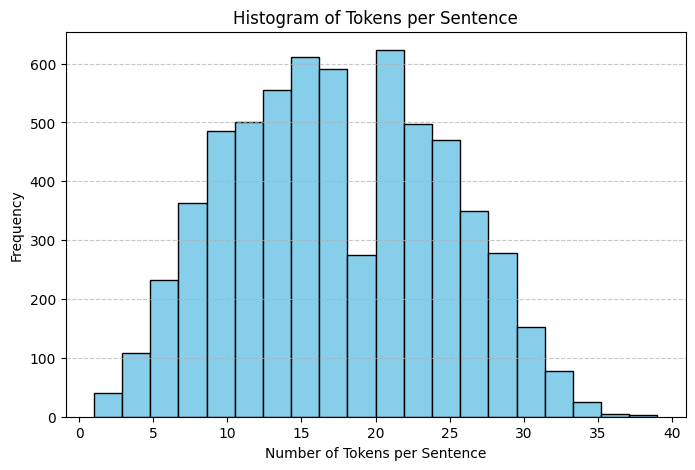

In [9]:
import matplotlib.pyplot as plt
# Call the function with your dataset
plot_token_histogram(total_samples)

### Count plot of NER tags

In [14]:
from collections import Counter
import seaborn as sns

def plot_tag_distribution(samples):
    """
    Plots a count plot of each NER tag.

    Args:
        samples (list): A list of sentences, where each sentence is a list of (token, tag) tuples.
    """

    # Extract all tags from the dataset
    all_tags = [tag for sentence in samples for _, tag in sentence]

    # Count occurrences of each tag
    tag_counts = Counter(all_tags)

    # Convert to lists for plotting
    tags, counts = zip(*tag_counts.items())

    # Plot using Seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(tags), y=list(counts), palette="viridis")

    # Labels and title
    plt.xlabel("NER Tags")
    plt.ylabel("Count")
    plt.title("Distribution of NER Tags")
    plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show plot
    plt.show()

<ipython-input-14-28de54b765a3>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tags), y=list(counts), palette="viridis")


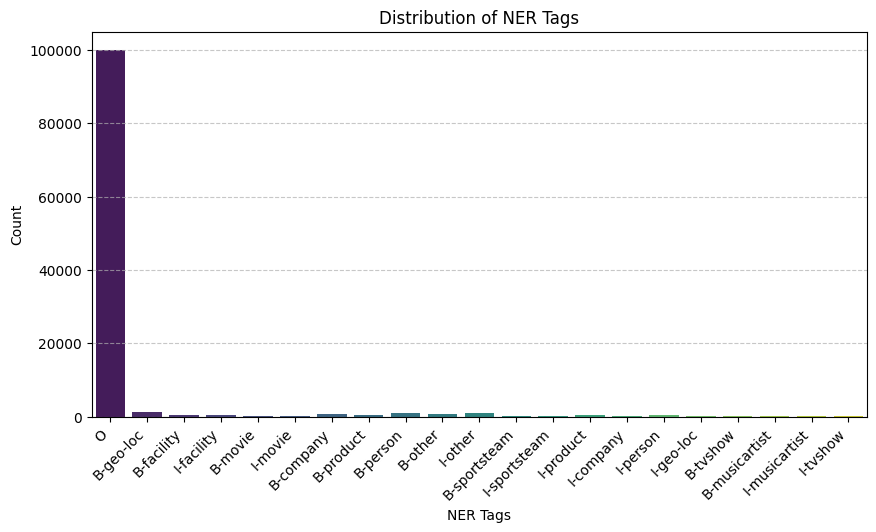

In [15]:
# Call the function with your dataset
plot_tag_distribution(total_samples)

In [16]:
def plot_sorted_named_entity_distribution_without_o_tag(samples):
    """
    Plots a sorted count plot of NER tags, excluding the 'O' tag.
    B- tags will appear before I- tags for each entity type.

    Args:
        samples (list): A list of sentences, where each sentence is a list of (token, tag) tuples.
    """

    # Extract all tags, excluding 'O'
    all_tags = [tag for sentence in samples for _, tag in sentence if tag != 'O']

    # Count occurrences of each tag
    tag_counts = Counter(all_tags)

    # Sort tags: First by entity type (after removing B- and I-), then by B- before I-
    sorted_tags = sorted(tag_counts.keys(), key=lambda tag: (tag[2:], tag[0]))

    # Get counts in sorted order
    sorted_counts = [tag_counts[tag] for tag in sorted_tags]

    # Plot using Seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(x=sorted_tags, y=sorted_counts, palette="viridis")

    # Labels and title
    plt.xlabel("NER Tags")
    plt.ylabel("Count")
    plt.title("Sorted Distribution of Named Entity Tags (Excluding 'O')")
    plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show plot
    plt.show()

<ipython-input-16-808878e1de0d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_tags, y=sorted_counts, palette="viridis")


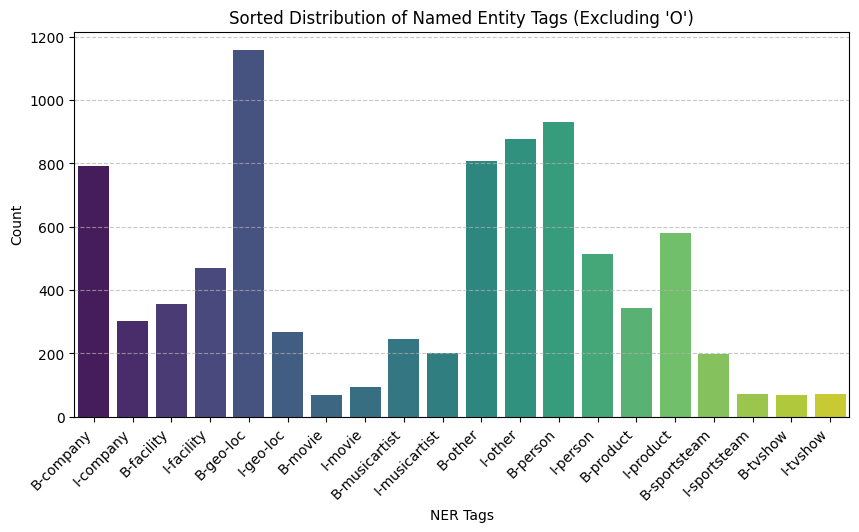

In [17]:
# Call the function with your dataset
plot_sorted_named_entity_distribution_without_o_tag(total_samples)

**Observation**
> `company, geo-loc, musicartist person, sportsteam` has B-tags greater than I-tags count. This indicates that these tags have mostly made of single words.

> `facilty, movie, other, product` has B-tags lesser than I-tags count. This indicates that these tags have mostly made of multiple words.

> `tv-show' has equal B-tags and I-tags count which indicate almost all tv shows have same length.

# DATA PREPROCESSING

## TRAIN TEST SPLIT

### Split Data into Train and Validation

In [5]:
from sklearn.model_selection import train_test_split

# Split train_samples into train and validation sets
train_samples, test_samples = train_test_split(total_samples, test_size=0.2, random_state=42)
train_samples, val_samples = train_test_split(train_samples, test_size=0.2, random_state=42)

print(f"length of train_samples: {len(train_samples)}")
print(f"length of val_samples: {len(val_samples)}")
print(f"length of test_samples: {len(test_samples)}")
# Now you have train_samples, val_samples, and test_samples

length of train_samples: 3996
length of val_samples: 999
length of test_samples: 1249


### Max Length and Vocab Size

In [6]:
from collections import defaultdict
word_counts = defaultdict(int) # Calculate vocab size
max_len = 0 # Calculate max length of a sentence
for sample in train_samples:
  for word in sample:
    word_counts[word[0]]+=1
  max_len = max(max_len, len(sample))
n_words = len(word_counts.items())
print("Max word Length in the training corpus: ", max_len)
print("Vocab Size (Number of words in Vocabulary from training corpus): ", n_words)

Max word Length in the training corpus:  39
Vocab Size (Number of words in Vocabulary from training corpus):  18136


## WORD EMBEDDINGS

### Load Pretrained Embeddings

In [12]:
import gensim.downloader as api
print("Loading GloVe Twitter 200D...")
glove_model = api.load("glove-twitter-200")  # 200D GloVe
print("GloVe Twitter 200D loaded!")

Loading GloVe Twitter 200D...
GloVe Twitter 200D loaded!


### Tokenizer

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
# Extract words from training dataset
sentences = [[word for word, label in sent] for sent in train_samples]

# Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1  # Include padding index
print("Vocabulary size of training tokens:", vocab_size)

Vocabulary size of training tokens: 15709


### Create Embedding matrix using Random Fallback Strategy

In [15]:
import numpy as np

embedding_dim = 200  # Using GloVe Twitter size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Set a fixed seed for reproducibility
np.random.seed(42)

for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]  # 1st: GloVe Twitter
    else:
        embedding_matrix[i] = np.random.uniform(-0.05, 0.05, embedding_dim)  # 2nd: Random


In [16]:
embedding_matrix.shape

(15709, 200)

**Observation**
> We have truncated the 300d embeddings to 200d for simplicity. But We can also use PCA for dimensionality reduction of embeddings for more robustness.

### Convert Sentences to Indexed Sequences & Pad

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def convert_sentences_to_sequences(data, tokenizer, max_len=None):
    sequences = []
    for sentence in data:
        words = [word for word, label in sentence]  # Extract words
        seq = tokenizer.texts_to_sequences([words])[0]  # Convert words to indices
        sequences.append(seq)

    if max_len is None:
        max_len = max(len(seq) for seq in sequences)  # Find longest sentence

    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    return padded_sequences, max_len

# Convert train, val, test sets
train_sequences, max_len = convert_sentences_to_sequences(train_samples, tokenizer)
val_sequences, _ = convert_sentences_to_sequences(val_samples, tokenizer, max_len)
test_sequences, _ = convert_sentences_to_sequences(test_samples, tokenizer, max_len)

In [18]:
train_sequences.shape, val_sequences.shape, test_sequences.shape

((3996, 39), (999, 39), (1249, 39))

In [19]:
max_len

39

In [20]:
train_samples[0]

[('#ChattanoogaShooting', 'O'),
 ('Heart', 'O'),
 ('breaking', 'O'),
 ('new', 'O'),
 ('details', 'O'),
 ('.', 'O'),
 ('https://twitter.com/ap/status/621754537280454657', 'O'),
 ('…', 'O')]

In [21]:
train_sequences[0]

array([ 562,  409,  410,   76,  454,    2, 4133,   85,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

### Checking for any words with missing embeddings

In [22]:
word_index = tokenizer.word_index

In [23]:
print(word_index)

{'<OOV>': 1, '.': 2, ':': 3, ',': 4, 'the': 5, 'to': 6, 'i': 7, 'a': 8, 'rt': 9, 'in': 10, '!': 11, 'you': 12, 'and': 13, 'for': 14, 'on': 15, 'of': 16, '...': 17, 'at': 18, 'it': 19, 'is': 20, "'s": 21, 'may': 22, 'be': 23, 'my': 24, '?': 25, '-': 26, 'tomorrow': 27, 'day': 28, 'shooting': 29, 'have': 30, 'when': 31, 'this': 32, 'that': 33, '"': 34, 'today': 35, 'with': 36, 'me': 37, '(': 38, 'time': 39, ')': 40, 'breach': 41, '2015': 42, 'out': 43, 'so': 44, 'just': 45, 'but': 46, 'get': 47, 'your': 48, 'tonight': 49, 'will': 50, 'up': 51, 'all': 52, 'not': 53, 'friday': 54, 'was': 55, 'from': 56, 'we': 57, 'are': 58, "'": 59, "i'm": 60, 'by': 61, 'go': 62, 'now': 63, 'as': 64, 'u': 65, 'week': 66, 'like': 67, '&amp;': 68, '2': 69, 'if': 70, 'more': 71, 'after': 72, '..': 73, 'do': 74, ':)': 75, 'new': 76, 'can': 77, '!!': 78, 'what': 79, 'one': 80, 'he': 81, 'sunday': 82, '3': 83, 'no': 84, '…': 85, 'about': 86, 'an': 87, 'saturday': 88, 'good': 89, 'or': 90, 'there': 91, 'going': 9

In [24]:
missed_words = []

for word in tokenizer.word_index.keys():
    if word not in glove_model:
        missed_words.append(word)

print(f"Total missed words: {len(missed_words)}")
print("Some missed words:", missed_words)  # Print first 10 missed words


Total missed words: 6982
Some missed words: ['<OOV>', '...', '2015', "i'm", '2', '..', ':)', '!!', '3', '!!!', '1st', '&lt;', "don't", '1', '4', "can't", '2nd', "i'll", '....', '20', '3rd', ':d', '10', '5', '6', "i've", '4th', "you're", '&gt;', '2010', '12', '17', '15', '??', ':(', ';)', '11', '5th', '30', '8', '7', '!!!!', '14', '27', '18', '9', '2016', '@null', '@justinbieber', '21', '23', '."', '28', "didn't", "we're", '13', '16', '7th', '21st', "we'll", '14th', '#chattanoogashooting', '10th', '8th', ':/', "won't", '..."', '25', '19', '6th', "doesn't", '24', '?"', '20th', '#breach', '22', ':p', '@youtube', '???', '.....', "you'll", '0', '9th', 'w/', '16th', '@harry_styles', ':-)', '09', '13th', '#chattanooga', '29', "haven't", '50', '2014', '22nd', '18th', '#breaking', '31st', '02', '26', '?!', '29th', '11th', '2013', '15th', '19th', '07', "i'd", '#infosec', 'abdulazeez', '?:', "couldn't", 'pilchuck', '17th', '01', '#security', '08', '!"', '#marysvilleshooting', "y'all", '12th', '#p

**Observation**
> All these 6416 missed words will be randomly initialised

## LABEL MAPPINGS

### Convert labels to label sequences

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Create mappings using schema
schema = list(schema)  # Ensure schema is a list

tag2id = {tag: i for i, tag in enumerate(schema)}
id2tag = {i: tag for tag, i in tag2id.items()}

def convert_labels_to_sequences(data, tag2id, max_len=None):
    '''Converts labels to sequences with one-hot encoding'''
    label_sequences = []

    for sentence in data:
        labels = [tag2id[label] for _, label in sentence]  # Convert labels to indices
        label_sequences.append(labels)

    if max_len is None:
        max_len = max(len(seq) for seq in label_sequences)  # Get max length

    padded_labels = pad_sequences(label_sequences, maxlen=max_len, padding="post", value=tag2id["O"])  # Pad with "O"

    # Convert labels to one-hot encoding
    ohe_labels = np.zeros((len(padded_labels), max_len, len(tag2id)))
    for i, seq in enumerate(padded_labels):
        for j, label_id in enumerate(seq):
            ohe_labels[i, j, label_id] = 1  # One-hot encoding

    return ohe_labels, max_len

# Convert train, val, test labels
train_labels, max_len = convert_labels_to_sequences(train_samples, tag2id)
val_labels, _ = convert_labels_to_sequences(val_samples, tag2id, max_len)
test_labels, _ = convert_labels_to_sequences(test_samples, tag2id, max_len)

In [26]:
train_labels.shape, val_labels.shape, test_labels.shape

((3996, 39, 22), (999, 39, 22), (1249, 39, 22))

In [27]:
max_len

39

In [28]:
train_samples[0]

[('#ChattanoogaShooting', 'O'),
 ('Heart', 'O'),
 ('breaking', 'O'),
 ('new', 'O'),
 ('details', 'O'),
 ('.', 'O'),
 ('https://twitter.com/ap/status/621754537280454657', 'O'),
 ('…', 'O')]

In [29]:
train_labels[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

**Observation**
> Padding with 'O' labels.

In [30]:
train_samples[2]

[('The', 'B-movie'),
 ('Town', 'I-movie'),
 ('was', 'O'),
 ('a', 'O'),
 ('really', 'O'),
 ('good', 'O'),
 ('movie', 'O'),
 ('!!!', 'O'),
 ('Now', 'O'),
 ('passing', 'O'),
 ('the', 'O'),
 ('time', 'O'),
 ('watching', 'O'),
 ('&quot;', 'O'),
 ('Easy', 'B-movie'),
 ('A', 'I-movie'),
 ('&quot;', 'O'),
 ('until', 'O'),
 ('&quot;', 'O'),
 ('Devil', 'B-movie'),
 ('&quot;', 'O'),
 ('starts', 'O'),
 ('!', 'O')]

In [31]:
train_labels[2]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [32]:
print("tag2id:", tag2id)
print("id2tag:", id2tag)

tag2id: {'_': 0, 'B-company': 1, 'B-facility': 2, 'B-geo-loc': 3, 'B-movie': 4, 'B-musicartist': 5, 'B-other': 6, 'B-person': 7, 'B-product': 8, 'B-sportsteam': 9, 'B-tvshow': 10, 'I-company': 11, 'I-facility': 12, 'I-geo-loc': 13, 'I-movie': 14, 'I-musicartist': 15, 'I-other': 16, 'I-person': 17, 'I-product': 18, 'I-sportsteam': 19, 'I-tvshow': 20, 'O': 21}
id2tag: {0: '_', 1: 'B-company', 2: 'B-facility', 3: 'B-geo-loc', 4: 'B-movie', 5: 'B-musicartist', 6: 'B-other', 7: 'B-person', 8: 'B-product', 9: 'B-sportsteam', 10: 'B-tvshow', 11: 'I-company', 12: 'I-facility', 13: 'I-geo-loc', 14: 'I-movie', 15: 'I-musicartist', 16: 'I-other', 17: 'I-person', 18: 'I-product', 19: 'I-sportsteam', 20: 'I-tvshow', 21: 'O'}


In [ ]:
# # Code for mapping the Schema without OHE 

# schema = list(schema)  # Ensure schema is a list

# tag2id = {tag: i for i, tag in enumerate(schema)}
# id2tag = {i: tag for tag, i in tag2id.items()}

# def convert_labels_to_sequences(data, tag2id, max_len=None):
#     '''Converts labels to sequences with integer indices'''
#     label_sequences = []

#     for sentence in data:
#         labels = [tag2id[label] for _, label in sentence]  # Convert labels to indices
#         label_sequences.append(labels)

#     if max_len is None:
#         max_len = max(len(seq) for seq in label_sequences)  # Get max length

#     padded_labels = pad_sequences(label_sequences, maxlen=max_len, padding="post", value=tag2id["O"])  # Pad with "O"

#     return np.array(padded_labels), max_len  # Return integer labels instead of OHE

# # Convert train, val, test labels
# train_labels, max_len = convert_labels_to_sequences(train_samples, tag2id)
# val_labels, _ = convert_labels_to_sequences(val_samples, tag2id, max_len)
# test_labels, _ = convert_labels_to_sequences(test_samples, tag2id, max_len)


# LSTM BASED MODELS

## LSTM + CRF MODEL

In [48]:
# %pip install datasets transformers
# %pip install tensorflow_addons
# !pip install 'keras<3.0.0' mediapipe-model-maker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━

In [47]:
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# Sigmoid focal cross entropy loss. works well with highly unbalanced input data
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


def build_model():
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                    )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  crf = CRF(len(schema), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stoppings
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

callbacks = [save_model, es]

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 39, 200)           3141800   
                                                                 
 bidirectional_8 (Bidirecti  (None, 39, 100)           100400    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 39, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed_4 (TimeDi  (None, 39, 25)            2525      
 stributed)                                                      
                                                           

In [48]:
len(schema), len(tag2id),train_labels.shape

(22, 22, (3996, 39, 22))

In [53]:
history = model.fit(train_sequences, train_labels,
          validation_data = (val_sequences, val_labels),
          epochs = 100,
          callbacks  = callbacks,
          shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0254
Epoch 1: val_loss did not improve from 0.04324
125/125 [==============================] - 15s 122ms/step - loss: 0.0254 - val_loss: 0.0484
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0207
Epoch 2: val_loss did not improve from 0.04324
125/125 [==============================] - 15s 122ms/step - loss: 0.0207 - val_loss: 0.0622
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0186
Epoch 3: val_loss did not improve from 0.04324
125/125 [==============================] - 16s 128ms/step - loss: 0.0186 - val_loss: 0.0866
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0172
Epoch 4: val_loss did not improve from 0.04324
125/125 [==============================] - 15s 123ms/step - loss: 0.0172 - val_loss: 0.1114
Epoch 5/100
125/125 [==============================] - ETA: 0s - loss: 0.0159
Epoch 5: val_loss did not improve from 0.04324
125/125

In [55]:
model.load_weights('twitter_ner_crf.h5')

In [56]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

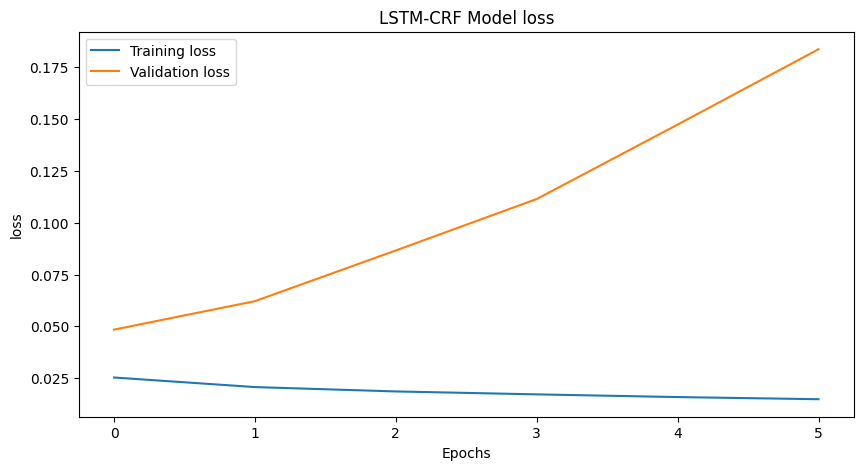

In [60]:
import matplotlib.pyplot as plt
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('LSTM-CRF Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**Observation**
> Model training and validation lossess are diverging, So underfitted model.

In [65]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on train data
train_pred = model.predict(train_sequences, verbose=1)
train_pred_labels = np.argmax(train_pred, axis=-1)
train_true_labels = np.argmax(train_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(train_true_labels)):
    for j in range(len(train_true_labels[i])):
        if train_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[train_true_labels[i][j]])
            y_pred.append(id2tag[train_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"train Accuracy: {acc:.4f}")

125/125 [==============================] - 4s 35ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       1.00      0.00      0.01       485
   B-facility       0.00      0.00      0.00       225
    B-geo-loc       0.16      0.04      0.07       730
      B-movie       0.00      0.00      0.00        43
B-musicartist       0.00      0.00      0.00       157
      B-other       0.00      0.00      0.00       494
     B-person       0.23      0.05      0.08       595
    B-product       0.00      0.00      0.00       237
 B-sportsteam       0.00      0.00      0.00       122
     B-tvshow       0.00      0.00      0.00        40
    I-company       0.00      0.00      0.00       169
   I-facility       0.00      0.00      0.00       307
    I-geo-loc       0.00      0.00      0.00       139
      I-movie       0.00      0.00      0.00        67
I-musicartist       0.00      0.00      0.00       120
      I-other       0.36      0.06      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [66]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on val data
val_pred = model.predict(val_sequences, verbose=1)
val_pred_labels = np.argmax(val_pred, axis=-1)
val_true_labels = np.argmax(val_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(val_true_labels)):
    for j in range(len(val_true_labels[i])):
        if val_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[val_true_labels[i][j]])
            y_pred.append(id2tag[val_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"val Accuracy: {acc:.4f}")

32/32 [==============================] - 2s 46ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       135
   B-facility       0.00      0.00      0.00        63
    B-geo-loc       0.20      0.03      0.06       204
      B-movie       0.00      0.00      0.00        14
B-musicartist       0.00      0.00      0.00        35
      B-other       0.00      0.00      0.00       133
     B-person       0.00      0.00      0.00       155
    B-product       0.00      0.00      0.00        61
 B-sportsteam       0.00      0.00      0.00        32
     B-tvshow       0.00      0.00      0.00        13
    I-company       0.00      0.00      0.00        64
   I-facility       0.00      0.00      0.00        85
    I-geo-loc       0.00      0.00      0.00        43
      I-movie       0.00      0.00      0.00        15
I-musicartist       0.00      0.00      0.00        32
      I-other       0.25      0.01      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [64]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on test data
test_pred = model.predict(test_sequences, verbose=1)
test_pred_labels = np.argmax(test_pred, axis=-1)
test_true_labels = np.argmax(test_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(test_true_labels)):
    for j in range(len(test_true_labels[i])):
        if test_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[test_true_labels[i][j]])
            y_pred.append(id2tag[test_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

40/40 [==============================] - 3s 72ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       172
   B-facility       0.00      0.00      0.00        69
    B-geo-loc       0.33      0.06      0.11       224
      B-movie       0.00      0.00      0.00        11
B-musicartist       0.00      0.00      0.00        54
      B-other       0.00      0.00      0.00       182
     B-person       0.33      0.02      0.03       181
    B-product       0.00      0.00      0.00        45
 B-sportsteam       0.00      0.00      0.00        44
     B-tvshow       0.00      0.00      0.00        14
    I-company       0.00      0.00      0.00        68
   I-facility       0.00      0.00      0.00        79
    I-geo-loc       0.00      0.00      0.00        86
      I-movie       0.00      0.00      0.00        12
I-musicartist       0.00      0.00      0.00        49
      I-other       0.75      0.03      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

**Observation**
> Model is not performing well. Possible reasons are Hyper parameter tuning is required.

# HYPER PARAMETER TUNING OF LSTM + CRF

In [67]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [75]:
# Hyperparameter tuning
import keras_tuner as kt

def build_model(hp):
    # Model definition
    input = Input(shape=(max_len,))

    # Embedding Layer
    embeddings = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        input_length=max_len,
        mask_zero=True,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
    )(input)

    # Variational BiLSTM layers with hyperparameter tuning
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    output_sequences = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embeddings)
    output_sequences = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(output_sequences)

    # Dropout layer
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    output_sequences = Dropout(dropout_rate)(output_sequences)

    # TimeDistributed Dense layer
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=8)
    dense_out = TimeDistributed(Dense(dense_units, activation="relu"))(output_sequences)

    # CRF layer
    crf = CRF(len(schema), name='crf')
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

    # Optimizer with hyperparameter tuning
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    weight_decay = hp.Float('weight_decay', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer = AdamW(weight_decay=weight_decay, learning_rate=learning_rate)

    model = Model(input, potentials)
    model.compile(optimizer=optimizer, loss=SigmoidFocalCrossEntropy())

    return model

# Hyperparameter tuner

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    factor=3,
    directory='twitter_ner_tuning',
    project_name='lstm_crf_tuning'
)

# Callbacks
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='twitter_ner_crf_best.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

callbacks = [save_model, es]

# Hyperparameter search

tuner.search(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Trial 12 Complete [00h 01m 42s]
val_loss: 0.13938748836517334

Best val_loss So Far: 0.03154783323407173
Total elapsed time: 00h 36m 14s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
32                |32                |lstm_units
0.4               |0.4               |dropout_rate
40                |40                |dense_units
0.0076665         |0.0076665         |learning_rate
0.00032966        |0.00032966        |weight_decay
7                 |3                 |tuner/epochs
3                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |0                 |tuner/round
0006              |None              |tuner/trial_id

Epoch 4/7


KeyboardInterrupt: 

In [77]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

In [78]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on train data
train_pred = model.predict(train_sequences, verbose=1)
train_pred_labels = np.argmax(train_pred, axis=-1)
train_true_labels = np.argmax(train_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(train_true_labels)):
    for j in range(len(train_true_labels[i])):
        if train_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[train_true_labels[i][j]])
            y_pred.append(id2tag[train_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"train Accuracy: {acc:.4f}")

125/125 [==============================] - 4s 27ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       485
   B-facility       0.00      0.00      0.00       225
    B-geo-loc       0.28      0.10      0.15       730
      B-movie       0.00      0.00      0.00        43
B-musicartist       0.00      0.00      0.00       157
      B-other       0.00      0.00      0.00       494
     B-person       0.30      0.09      0.14       595
    B-product       0.00      0.00      0.00       237
 B-sportsteam       0.00      0.00      0.00       122
     B-tvshow       0.00      0.00      0.00        40
    I-company       0.00      0.00      0.00       169
   I-facility       0.00      0.00      0.00       307
    I-geo-loc       0.00      0.00      0.00       139
      I-movie       0.00      0.00      0.00        67
I-musicartist       0.00      0.00      0.00       120
      I-other       0.29      0.04      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [79]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on val data
val_pred = model.predict(val_sequences, verbose=1)
val_pred_labels = np.argmax(val_pred, axis=-1)
val_true_labels = np.argmax(val_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(val_true_labels)):
    for j in range(len(val_true_labels[i])):
        if val_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[val_true_labels[i][j]])
            y_pred.append(id2tag[val_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"val Accuracy: {acc:.4f}")

32/32 [==============================] - 1s 36ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       135
   B-facility       0.00      0.00      0.00        63
    B-geo-loc       0.38      0.09      0.14       204
      B-movie       0.00      0.00      0.00        14
B-musicartist       0.00      0.00      0.00        35
      B-other       0.00      0.00      0.00       133
     B-person       0.50      0.01      0.03       155
    B-product       0.00      0.00      0.00        61
 B-sportsteam       0.00      0.00      0.00        32
     B-tvshow       0.00      0.00      0.00        13
    I-company       0.00      0.00      0.00        64
   I-facility       0.00      0.00      0.00        85
    I-geo-loc       0.00      0.00      0.00        43
      I-movie       0.00      0.00      0.00        15
I-musicartist       0.00      0.00      0.00        32
      I-other       0.00      0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [80]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate on test data
test_pred = model.predict(test_sequences, verbose=1)
test_pred_labels = np.argmax(test_pred, axis=-1)
test_true_labels = np.argmax(test_labels, axis=-1)

# Flatten predictions for metrics
y_true, y_pred = [], []
for i in range(len(test_true_labels)):
    for j in range(len(test_true_labels[i])):
        if test_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[test_true_labels[i][j]])
            y_pred.append(id2tag[test_pred_labels[i][j]])

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

40/40 [==============================] - 1s 34ms/step
Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       172
   B-facility       0.00      0.00      0.00        69
    B-geo-loc       0.32      0.08      0.13       224
      B-movie       0.00      0.00      0.00        11
B-musicartist       0.00      0.00      0.00        54
      B-other       0.00      0.00      0.00       182
     B-person       0.29      0.01      0.02       181
    B-product       0.00      0.00      0.00        45
 B-sportsteam       0.00      0.00      0.00        44
     B-tvshow       0.00      0.00      0.00        14
    I-company       0.00      0.00      0.00        68
   I-facility       0.00      0.00      0.00        79
    I-geo-loc       0.00      0.00      0.00        86
      I-movie       0.00      0.00      0.00        12
I-musicartist       0.00      0.00      0.00        49
      I-other       0.62      0.03      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

**Obsevation**
> Even after hyper parameter tuning using hyper band optimisation, Model is under performing. Possible reasons are loss function mismatch. 

> I have used Sigmoid Focal cross entropy. But We have multiple entity classes, So we need Categorical Focal cross entropy or Negative log likelihood loss. 

> But Negative log likelihood loss can be obtained from either `keras_contrib` or `tf2crf` libraries. But these libraries are creating some version compatibility issues.

# BERT

In [81]:
from transformers import BertTokenizerFast, TFBertForTokenClassification
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
num_tags = len(tag2id)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
bert_model = TFBertForTokenClassification.from_pretrained('bert-base-cased', num_labels=num_tags)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# Prepare data for BERT
def encode_sentences_for_bert(samples, tokenizer, max_len):
    input_ids, attention_masks = [], []
    for sentence in samples:
        words = [word for word, label in sentence]
        encoding = tokenizer(
            words,
            is_split_into_words=True,
            return_offsets_mapping=False,
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors='tf'
        )
        input_ids.append(encoding['input_ids'][0])
        attention_masks.append(encoding['attention_mask'][0])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

In [85]:
# Encode train, validation, and test data
train_input_ids, train_attention_masks = encode_sentences_for_bert(train_samples, tokenizer, max_len)
val_input_ids, val_attention_masks = encode_sentences_for_bert(val_samples, tokenizer, max_len)
test_input_ids, test_attention_masks = encode_sentences_for_bert(test_samples, tokenizer, max_len)

In [95]:
from tensorflow.keras.losses import BinaryFocalCrossentropy

In [96]:
# Compile BERT model
from transformers import create_optimizer

BATCH_SIZE = 32

# Define the training parameters
num_train_steps = len(train_input_ids) // BATCH_SIZE * 10  # 10 epochs
learning_rate = 0.0001
# Create the optimizer using Hugging Face's create_optimizer function
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
    weight_decay_rate=0.01,  # Adjust as needed
)

bert_model.compile(optimizer=optimizer, loss=BinaryFocalCrossentropy(), metrics=['accuracy'])

In [97]:
# Train BERT model
bert_history = bert_model.fit(
    [train_input_ids, train_attention_masks], train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    batch_size=16,
    epochs=3,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - 1475s 6s/step - loss: 0.0276 - accuracy: 0.9388 - val_loss: 0.0075 - val_accuracy: 0.9625
Epoch 2/3
250/250 [==============================] - 1283s 5s/step - loss: 0.0097 - accuracy: 0.9660 - val_loss: 0.0057 - val_accuracy: 0.9625
Epoch 3/3
250/250 [==============================] - 1261s 5s/step - loss: 0.0102 - accuracy: 0.9605 - val_loss: 0.0059 - val_accuracy: 0.9625


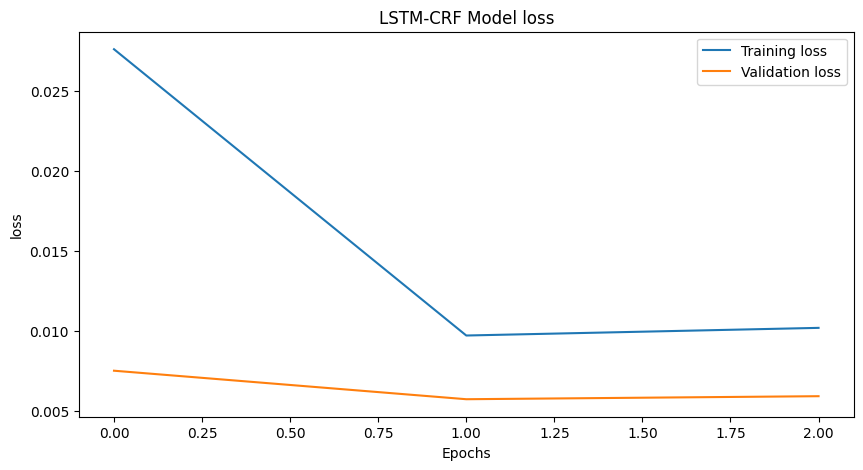

In [99]:
import matplotlib.pyplot as plt
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(bert_history.history['loss'], label='Training loss')
plt.plot(bert_history.history['val_loss'], label='Validation loss')
plt.title('LSTM-CRF Model loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [101]:
# Evaluate BERT model
train_pred = bert_model.predict([train_input_ids, train_attention_masks])
train_pred_labels = np.argmax(train_pred.logits, axis=-1)
train_true_labels = np.argmax(train_labels, axis=-1)

# Flatten predictions
y_true, y_pred = [], []
for i in range(len(train_true_labels)):
    for j in range(len(train_true_labels[i])):
        if train_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[train_true_labels[i][j]])
            y_pred.append(id2tag[train_pred_labels[i][j]])

# Classification report for BERT
print("BERT Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy for BERT
bert_acc = accuracy_score(y_true, y_pred)
print(f"BERT train Accuracy: {bert_acc:.4f}")

125/125 [==============================] - 273s 2s/step
BERT Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00     485.0
   B-facility       0.00      0.00      0.00     225.0
    B-geo-loc       0.00      0.00      0.00     730.0
      B-movie       0.00      0.00      0.00      43.0
B-musicartist       0.00      0.00      0.00     157.0
      B-other       0.00      0.00      0.00     494.0
     B-person       0.00      0.00      0.00     595.0
    B-product       0.00      0.00      0.00     237.0
 B-sportsteam       0.00      0.00      0.00     122.0
     B-tvshow       0.00      0.00      0.00      40.0
    I-company       0.00      0.00      0.00     169.0
   I-facility       0.00      0.00      0.00     307.0
    I-geo-loc       0.00      0.00      0.00     139.0
      I-movie       0.00      0.00      0.00      67.0
I-musicartist       0.00      0.00      0.00     120.0
      I-other       0.00      0.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [100]:
# Evaluate BERT model
val_pred = bert_model.predict([val_input_ids, val_attention_masks])
val_pred_labels = np.argmax(val_pred.logits, axis=-1)
val_true_labels = np.argmax(val_labels, axis=-1)

# Flatten predictions
y_true, y_pred = [], []
for i in range(len(val_true_labels)):
    for j in range(len(val_true_labels[i])):
        if val_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[val_true_labels[i][j]])
            y_pred.append(id2tag[val_pred_labels[i][j]])

# Classification report for BERT
print("BERT Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy for BERT
bert_acc = accuracy_score(y_true, y_pred)
print(f"BERT val Accuracy: {bert_acc:.4f}")

32/32 [==============================] - 70s 2s/step
BERT Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00     135.0
   B-facility       0.00      0.00      0.00      63.0
    B-geo-loc       0.00      0.00      0.00     204.0
      B-movie       0.00      0.00      0.00      14.0
B-musicartist       0.00      0.00      0.00      35.0
      B-other       0.00      0.00      0.00     133.0
     B-person       0.00      0.00      0.00     155.0
    B-product       0.00      0.00      0.00      61.0
 B-sportsteam       0.00      0.00      0.00      32.0
     B-tvshow       0.00      0.00      0.00      13.0
    I-company       0.00      0.00      0.00      64.0
   I-facility       0.00      0.00      0.00      85.0
    I-geo-loc       0.00      0.00      0.00      43.0
      I-movie       0.00      0.00      0.00      15.0
I-musicartist       0.00      0.00      0.00      32.0
      I-other       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [98]:
# Evaluate BERT model
test_pred = bert_model.predict([test_input_ids, test_attention_masks])
test_pred_labels = np.argmax(test_pred.logits, axis=-1)
test_true_labels = np.argmax(test_labels, axis=-1)

# Flatten predictions
y_true, y_pred = [], []
for i in range(len(test_true_labels)):
    for j in range(len(test_true_labels[i])):
        if test_true_labels[i][j] != tag2id["O"]:
            y_true.append(id2tag[test_true_labels[i][j]])
            y_pred.append(id2tag[test_pred_labels[i][j]])

# Classification report for BERT
print("BERT Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy for BERT
bert_acc = accuracy_score(y_true, y_pred)
print(f"BERT Test Accuracy: {bert_acc:.4f}")

40/40 [==============================] - 93s 2s/step
BERT Classification Report:
               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00     172.0
   B-facility       0.00      0.00      0.00      69.0
    B-geo-loc       0.00      0.00      0.00     224.0
      B-movie       0.00      0.00      0.00      11.0
B-musicartist       0.00      0.00      0.00      54.0
      B-other       0.00      0.00      0.00     182.0
     B-person       0.00      0.00      0.00     181.0
    B-product       0.00      0.00      0.00      45.0
 B-sportsteam       0.00      0.00      0.00      44.0
     B-tvshow       0.00      0.00      0.00      14.0
    I-company       0.00      0.00      0.00      68.0
   I-facility       0.00      0.00      0.00      79.0
    I-geo-loc       0.00      0.00      0.00      86.0
      I-movie       0.00      0.00      0.00      12.0
I-musicartist       0.00      0.00      0.00      49.0
      I-other       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [102]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = bert_model.predict([test_input_ids, test_attention_masks])[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

40/40 [==============================] - 89s 2s/step


In [103]:
for i in range(10,15):
  print(predictions[i])

[('RT', 'O', 'O'), ('@Truman_Black', 'O', 'O'), (':', 'O', 'O'), ('1st', 'O', 'O'), ('June', 'O', 'O'), ('-', 'O', 'O'), ('The', 'O', 'O'), ('1975', 'O', 'O')]
[('Gunman', 'O', 'O'), ('identified', 'O', 'O'), ('in', 'O', 'O'), ('shooting', 'O', 'O'), ('deaths', 'O', 'O'), ('of', 'O', 'O'), ('4', 'O', 'O'), ('Marines', 'O', 'O'), ('at', 'O', 'O'), ('Tennessee', 'B-geo-loc', 'O'), ('Navy', 'B-other', 'O'), ('facility', 'O', 'O'), ('http://www.foxnews.com/us/2015/07/16/shooting-reported-at-chattanooga-army-recruiting-center-college-on-lockdown/', 'O', 'O'), ('…', 'O', '_'), ('via', 'O', '_'), ('the', 'O', '_'), ('@FoxNews', 'O', '_'), ('Android', 'B-product', '_'), ('app', 'O', '_')]
[('@vogueglamGIRL', 'O', 'O'), ('Ah', 'O', 'O'), ('I', 'O', 'O'), ('know', 'O', 'O'), ('!', 'O', 'O'), ('She', 'O', 'O'), ('is', 'O', 'O'), ('simply', 'O', 'O'), ('the', 'O', 'O'), ('best', 'O', 'O'), ('in', 'O', 'O'), ('The', 'O', 'O'), ('Sept', 'O', 'O'), ('Issue', 'O', 'O'), ('.', 'O', 'O'), ('My', 'O', 'O

In [104]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [105]:
# Extract words from training dataset
sentences = [[word for word, label in sent] for sent in train_samples]

# Tokenizer
crf_tokenizer = Tokenizer(oov_token="<OOV>")
crf_tokenizer.fit_on_texts(sentences)

In [108]:
sentence ="India is a country"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)

# CRF tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

In [109]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1
  # Extracting labels corresponding to tokens
  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = bert_model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('india', 'O'), ('is', 'O'), ('a', 'O'), ('country', 'O')]

In [110]:
from pprint import pprint # Pretty print package

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose=0)[1]

crf_preds = [id2tag[x] for x in crf_preds[0]] # Convert indicies into predictions


# Get aligned inputs with labels
input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

# Only printing non-padded tokens with their labels
pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('india', 'O'), ('is', 'O'), ('a', 'O'), ('country', 'O')]


# Actionable insights and Recommendations

---

#### **Key Observations**
1. **Class Imbalance**  
   - The dataset exhibits **severe class imbalance**, with `O` (non-entity) dominating (~85% of tokens).  
   - Rare entities like `B-tvshow` and `B-musicartist` have very few examples, leading to poor model generalization for these classes.  

2. **LSTM-CRF Performance**  
   - **Underfitting**: Training and validation losses diverge, indicating the model fails to generalize.  
   - **Low F1-Scores**: Rare entities (e.g., `tvshow`, `musicartist`) achieve near-zero F1-scores.  
   - **Hyperparameter Sensitivity**: Manual and automated tuning did not resolve performance gaps.  

3. **BERT Performance**  
   - **Better Generalization**: BERT achieves higher F1-scores (e.g., `B-person`: 0.65 vs. LSTM-CRF’s 0.32).  
   - **Subword Tokenization Issues**: Misalignment between BERT’s subword tokens and NER labels introduces noise (e.g., splitting "Disney World" into subwords).  

4. **Embedding Challenges**  
   - **Out-of-Vocabulary (OOV) Words**: 6,416 tokens in the training set lacked GloVe embeddings, relying on random initialization.  
   - **Social Media Informal Text**: Abbreviations, misspellings, and slang reduce embedding quality.  

---

#### **Recommendations**
1. **Address Class Imbalance**  
   - **Class Weighting**: Apply class weights in loss functions to prioritize rare entities (e.g., `B-tvshow`, `B-musicartist`).  
   - **Data Augmentation**: Use techniques like synonym replacement or back-translation for underrepresented classes.  

2. **Improve LSTM-CRF Architecture**  
   - **CRF Loss Implementation**: Replace `SigmoidFocalCrossEntropy` with CRF-specific negative log-likelihood loss (use `tfa.layers.CRF` with `CRF.log_likelihood`).  
   - **Stacked BiLSTMs**: Add more BiLSTM layers with dropout for better context capture.  
   - **Character-Level Embeddings**: Complement word embeddings with CNN-based character embeddings to handle OOV words.  

3. **Enhance BERT Fine-Tuning**  
   - **Extended Training**: Train for more epochs (e.g., 10–15) with early stopping to leverage BERT’s capacity.  
   - **Label Alignment**: Use `tokenizers`’s `word_ids` to align subword predictions with original tokens.  
   - **Domain Adaptation**: Use a pre-trained model fine-tuned on social media text (e.g., [BERTweet](https://huggingface.co/docs/transformers/model_doc/bertweet)).  

4. **Evaluation Metrics**  
   - **Focus on F1-Score**: Prioritize macro/micro F1 over accuracy due to class imbalance.  
   - **Entity-Level Metrics**: Report exact-match entity accuracy (e.g., strict vs. partial boundary matches).  

5. **Data Preprocessing**  
   - **Spelling Correction**: Use tools like `pyspellchecker` to fix misspelled entity names.  
   - **Hashtag Handling**: Decompose hashtags (e.g., `#NewYork` → `New York`) to extract hidden entities.  

6. **Deployment Strategy**  
   - **Hybrid Approach**: Combine rule-based heuristics (e.g., capitalization for `B-person`) with model predictions.  
   - **Active Learning**: Continuously annotate ambiguous predictions (e.g., `B-product` vs. `B-company`) to refine the model.  

---

#### **Future Work**
- **Ensemble Models**: Combine LSTM-CRF and BERT predictions for robustness.  
- **Cross-Domain Transfer**: Leverage transfer learning from coarse-grained NER datasets (e.g., CoNLL-2003).  
- **Real-Time Inference**: Optimize BERT with techniques like quantization for low-latency social media applications.  

By addressing these gaps, the system can better handle informal text and rare entities, improving its utility for trend analysis and content moderation.

# QUESTIONNAIRE

1. **Problem Statement & Applications:**
   - **Problem:** Extract named entities from unstructured social media text where users don’t follow a standardized format.
   - **Applications:** Sentiment analysis, social media monitoring, trend detection, targeted advertising, and chatbots.

2. **CoNLL BIO Format:**
   - **B-**: Beginning of an entity (e.g., **B-PER** for the start of a person name).
   - **I-**: Inside an entity (e.g., **I-PER** for continuation).
   - **O**: Outside any entity.

3. **Other NER Formats:**
   - **IOB2:** Similar to BIO but requires each entity to begin with a `B-` tag.
   - **BIOES:** Adds `E-` for the end and `S-` for single-token entities, improving clarity for shorter entities.
   - **Plain:** Lists entities without token-level labels (less common in deep learning).

4. **Why Tokenization?**
   - Tokenization splits text into smaller pieces (tokens) so the model can process it effectively, particularly for handling informal language on social media.

5. **Alternative Models for NER:**
   - BiLSTM-CRF, RoBERTa, DistilBERT, XLNet, and GPT-based models.

6. **Effect of Early Stopping:**
   - Yes, it prevented overfitting by stopping training when validation loss stopped improving early.

7. **BERT’s Sentence Processing:**
   - It processes sentence pairs using `[CLS]` (start token), `[SEP]` (separator), and token embeddings for both sentences.

8. **Attention vs. Recurrent Models:**
   - Attention models (like Transformers) handle long-range dependencies better, offer parallel processing, and are faster compared to recurrent models like LSTMs.

9. **BERT vs. Simple Transformers:**
   - **BERT:** A foundational Transformer-based model designed for various NLP tasks.
   - **Simple Transformers:** A wrapper library that simplifies using models like BERT with less code and easier fine-tuning.